# An example of fitting the synthetic nascent signal data

In [1]:
using CSV, DataFrames
using Plots; theme(:vibrant)
using RNAInferenceTool, StatsBase

## Import data and load SSA functions

In [2]:
# Import SSA code install delay SSA package at https://github.com/palmtree2013/DelaySSAToolkit.jl
include("delaytelegraphSSA.jl")
# Parameters 
τ = 0.5
tf = 20 
params = [1.0526,8.2034,57.989,0,0,τ,tf] # σ_off, σ_on, ρ_on, ρ_off, d, τ, SSA final time
L1 = 862; L = 3062; # L1 =  signal fluorescence 862 bp; L = total gene 3062 bp 

3062

## Generate synthetic SSA signal data

In [3]:
numofRun = 10000 # delay SSA sample size
djprob = construct_prob_delaytelegraph(params)
ens_prob = EnsembleProblem(djprob)
ens = solve(ens_prob, SSAStepper(), EnsembleThreads(), trajectories = numofRun);

## Check the distribution

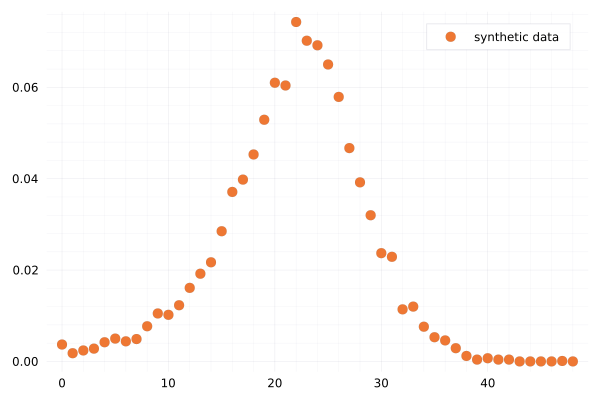

In [4]:
filter_pos_tf = [ens[i].channel[end][1] for i in eachindex(ens)]
res_ens = [signal_function.(filter_pos_tf[i], τ = τ, L1 = L1, L = L) for i in eachindex(filter_pos_tf)]
histo_synthetic = sum_with_non.(res_ens)
scatter(convert_histo(histo_synthetic), labels="synthetic data") # plot distribution

 # Inference

## load functions and set parameters

In [5]:
#For delay model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d, τ
SRange = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(0.0,0.0),(τ,τ)];

#For telegraph model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d
SRange_tele = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(1/τ,1/τ)];

The `OptimStruct` consists of four elements:
1. data: default type is histogram data; the other supported type is to use distribution directly;
2. stage: G1 or G2; where G2 type data is inferred by setting G2 = G1*G1 (convolution);
3. dist: the distance function: Likelihood, Likelihood_fusion, Likelihood_rejection and other distance functions in Distances.jl are supported;
4. model: telegraph model, delay telegraph model, bursty model and Poisson model are supported;

In [6]:
infer_struct = OptimStruct(histo_synthetic, G1(), Likelihood(), Delay())
infer_struct_tele = OptimStruct(histo_synthetic, G1(), Likelihood(), Telegraph())

OptimStruct{G1, Likelihood, Telegraph}([23.855873938651055, 11.822356993398493, 28.3382913394333, 22.393607581545616, 32.067884486035155, 28.530100197410114, 16.871123846060264, 13.640023919305278, 29.056401168829776, 36.61765848037979  …  24.86678151750219, 14.164619166106188, 31.02934397286886, 27.26543723311017, 21.099811262503824, 23.24675201851283, 23.53342793716659, 21.888230841411268, 19.821891397123572, 32.414995628399986], G1(), Likelihood(), Telegraph(), true)

In [7]:
estimated_params, distributions = optim_function(SRange, infer_struct, MaxFuncEvals = 10000, L1 = L1, L2 = L - L1)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.54 secs, 127 evals, 81 steps, improv/step: 0.407 (last = 0.4074), fitness=33199.087188224
1.04 secs, 338 evals, 257 steps, improv/step: 0.346 (last = 0.3182), fitness=33031.080828902
1.56 secs, 577 evals, 509 steps, improv/step: 0.297 (last = 0.2460), fitness=32921.684229961
2.06 secs, 834 evals, 789 steps, improv/step: 0.260 (last = 0.1929), fitness=32839.697140955
2.56 secs, 1093 evals, 1080 steps, improv/step: 0.240 (last = 0.1856), fitness=32727.187346124
3.06 secs, 1325 evals, 1343 steps, improv/step: 0.214 (last = 0.1103), fitness=32660.871701947
3.56 secs, 1555 evals, 1606 steps, improv/step: 0.210 (last = 0.1863), fitness=32630.305841497
4.10 secs, 1787 evals, 1867 steps, improv/step: 0.209 (last = 0.2031),

([0.8536531872850428, 7.371226886444456, 57.220665650890375, 0.0, 0.0, 0.5, 32613.564450069847], [0.004046744810324921 0.0037; 0.0018154245909310334 0.0018; … ; 1.3936039351263602e-10 0.0; 5.7781440335396484e-12 0.0])

In [8]:
estimated_params_tele, distributions_tele = optim_function(SRange_tele, infer_struct_tele, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.52 secs, 576 evals, 492 steps, improv/step: 0.317 (last = 0.3171), fitness=33120.954295654
1.07 secs, 1405 evals, 1396 steps, improv/step: 0.222 (last = 0.1704), fitness=33120.954295654
1.57 secs, 2120 evals, 2188 steps, improv/step: 0.205 (last = 0.1742), fitness=32816.706190408
2.07 secs, 2868 evals, 3023 steps, improv/step: 0.203 (last = 0.1988), fitness=32641.506161985
2.61 secs, 3620 evals, 3848 steps, improv/step: 0.201 (last = 0.1939), fitness=32638.417412790
3.12 secs, 4451 evals, 4768 steps, improv/step: 0.200 (last = 0.1957), fitness=32631.210187136
3.65 secs, 5284 evals, 5686 steps, improv/step: 0.204 (last = 0.2255), fitness=32631.028614277
4.23 secs, 6117 evals, 6605 steps, improv/step: 0.200 (last = 0

([0.3784417266537521, 3.1703455851577913, 57.35856561248517, 0.0, 2.0, 32631.02779521476], [0.0015194223432619587 0.0037; 0.0023995391649108628 0.0018; … ; 1.2955040001829928e-10 0.0; 5.37120487909273e-12 0.0])

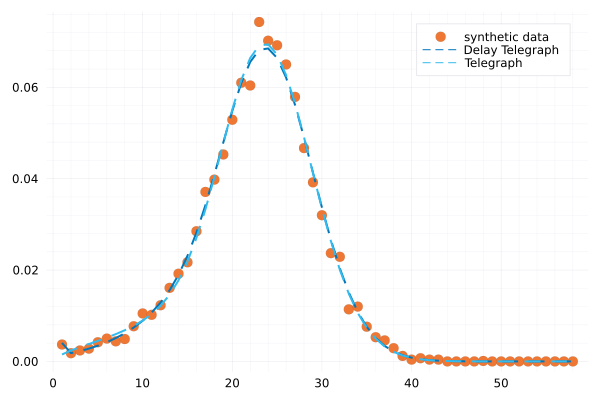

In [9]:
scatter(distributions[:,2],labels="synthetic data")
plot!([distributions[:,1] distributions_tele[:,1]],lines=(2, :dash),labels=["Delay Telegraph" "Telegraph"])

In [10]:
#Compare the paramters
DataFrame(True = params[1:3],Delay=estimated_params[1:3],Telegraph= estimated_params_tele[1:3])

,True,Delay,Telegraph
,Float64,Float64,Float64
1,1.0526,0.853653,0.378442
2,8.2034,7.37123,3.17035
3,57.989,57.2207,57.3586
